# Modelo para Zyfra

## Índice <a id='back'></a>
* [Introducción](#intro)
* [Etapa 1. Descripción y preprocesamiento de los datos](#data_review)
    * [1. 1. Información general de los datos](#data_review_data)
    * [1. 2. Cálculo de la recuperación](#data_review_recovery)
    * [1. 3. Columnas faltantes en el conjunto de prueba](#data_review_test)
    * [1. 4. Preprocesamiento de datos](#data_review_preprocessing)
    * [1. 5. Conclusiones](#data_review_conclusions)
* [Etapa 2. Análisis de datos](#data_analysis)
    * [2. 1. Concentrados de metales](#data_analysis_concentrate)
    * [2. 2. Tamaño de las partículas en la alimentación](#data_analysis_size)
    * [2. 3. Concentraciones totales](#data_analysis_total)
    * [2. 2. Conclusiones](#data_analysis_conclusions)
* [Etapa 3. Construcción del modelo](#data_model)
    * [3.1. Entrenamiento del modelo](#data_model_train)
    * [3.2. Prueba final](#data_model_test)
* [Etapa 4. Conclusión general](#data_conclusion)

## Introducción <a id='intro'></a>

La empresa Zyfra desarrolla soluciones de eficiencia para la industria pesada. Se quiere predecir la cantidad de oro extraído del mineral del oro. Para ello se cuentan con los datos de extracción y purificación.

**Objetivo**

El objetivo de este proyecto es crear un modelo para optimizar la producción y elimine los parámetros no rentables.

**Etapas**
Los datos se almacenan en tres archivos `/datasets/gold_recovery_full.csv`, `/datasets/gold_recovery_test.csv` y `/datasets/gold_recovery_train.csv`. Como se desconoce la calidad de los datos, el proyecto consistirá en cuatro etapas:

1. Descripción y preprocesamiento de los datos.
2. Análisis de datos.
3. Construcción del modelo.
4. Conclusión general.

[Volver a Contenidos](#back)

## Etapa 1. Descripción y preprocesamiento de los datos <a id='data_review'></a>

Se importan las librerías necesarias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

Se leerán los archivos y se guardaran en las variables `data`, `data_test` y `data_train`. 

In [2]:
def read(file, path):
    try:
        df = pd.read_csv(file)
    except:
        df = pd.read_csv(path)
    return df

data = read('gold_recovery_full.csv', '/datasets/gold_recovery_full.csv')
data_test = read('gold_recovery_test.csv', '/datasets/gold_recovery_test.csv')
data_train = read('gold_recovery_train.csv', '/datasets/gold_recovery_train.csv')

### 1. 1. Información general de los datos <a id='data_review_data'></a>

El mineral extraído se somete a un tratamiento primario para obtener la mezcla de mineral, o alimentación rougher, que es la materia prima utilizada para la flotación (también conocida como proceso rougher). De este proceso se obtiene un concentrado de oro rougher y colas rougher (es decir, residuos del producto con una baja concentración de metales valiosos).

Después de esto, el concentrado rougher se somete a dos etapas de purificación. Luego de esto, tenemos el concentrado final y las nuevas colas.

En el conjunto de datos se observarán columnas nombradas de la manera `[stage].[parameter_type].[parameter_name]` donde `[stage]` indica la etapa del proceso, las opciones son:

* `rougher` - flotación.
* `primary_cleaner` - purificación primaria.
* `secondary_cleaner` - purificación secundaria.
* `final` - características finales.

`[parameter_type]` indica los parámetros de la materia antes, durante o después de la etapa correspondiente, así como el cálculo de las características. Las opciones que puede tener son:

* `input` - parámetros de la materia prima (antes de la etapa).
* `output` - parámetros del producto (al termino de la etapa).
* `state` - parámetros que caracterizan el estado actual de la etapa.
* `calculation` - características de cálculo.

Y `[parameter_name]` indica el nombre del parámetro, las opciones que puede tener son:

* `concentrate` - concentrado de un metal (Ag, Pb, Au).
* `tail` - residuos del producto.
* `sulfate`, `depressant`, `xanthate` - reactivos de flotación.
* `feed_size` - tamaño de las partículas de la alimentación (es un parámetro de la etapa).
* `floatbank` - instalación de flotación.
* `recovery`- cálculo de la recuperación.

Se imprimirá la información general del conjunto de datos completo, el cual está en `data`, y las primeras 10 filas de éste para mayor investigación.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [4]:
data.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


Este dataset contiene 22,716 filas y 87 columnas.

Se muestra la información general de `data_test` y sus primeras 10 filas.

In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [6]:
data_test.head(10)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
5,2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
6,2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
7,2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
8,2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716
9,2016-09-01 09:59:59,126.961069,8.017856,7.030000,0.805298,1400.816120,-499.014158,1399.975401,-499.570552,1401.871924,...,12.040725,-499.987743,7.989503,-499.750625,7.989710,-509.946737,5.068811,-499.293900,24.992741,-499.272255


Este dataset contiene 5,856 filas y 53 columnas.

Se muestra la información general de `data_train` y sus primeras 10 filas.

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [8]:
data_train.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


Este dataset contiene 16,860 filas y 87 columnas. En los tres datasets se observa lo siguiente:

1. La columna `'date'` debe cambiarse a formato fecha.
2. Existen valores ausentes.

Así, los datos necesitan ser preparados antes de crear el modelo. Antes de esto, en la siguiente sección, se hará el cálculo de la recuperación en el conjunto de entrenamiento.

[Volver a Contenidos](#back)

### 1. 2. Cálculo de la recuperación <a id='data_review_recovery'></a>

Para realizar el cálculo de recuperación de la característica `rougher.output.recovery` es necesario:

1. `C` - proporción de oro en el concentrado justo después de la flotación.
2. `F` - proporción de oro en la alimentación antes de la flotación.
3. `T` - proporción de oro en las colas rougher justo después de la flotación.

Primero se creará un dataset sin valores ausentes en las columnas correspondientes a los valores necesarios (sobre el conjunto de entrenamiento) para no tener errores en este cálculo.

In [9]:
train_nonan = data_train.dropna(
    subset=['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au',
            'rougher.output.recovery']
)
train_nonan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14287 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14287 non-null  object 
 1   final.output.concentrate_ag                         14282 non-null  float64
 2   final.output.concentrate_pb                         14282 non-null  float64
 3   final.output.concentrate_sol                        14055 non-null  float64
 4   final.output.concentrate_au                         14283 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14287 non-null  float64
 7   final.output.tail_pb                                14173 non-null  float64
 8   final.output.tail_sol                               14279 non-null  float64
 9   

A continuación se creará una función para realizar el cálculo de la recuperación y posteriormente se aplique a cada fila del dataset.

In [10]:
def recovery_calc(row):
    C = row.loc['rougher.output.concentrate_au']
    F = row.loc['rougher.input.feed_au']
    T = row.loc['rougher.output.tail_au']
    recovery = ((C * (F - T)) / (F * (C - T))) * 100
    return recovery

Se aplica la función al dataset (creando una nueva columna `recovery`).

In [11]:
train_nonan['recovery'] = train_nonan.apply(recovery_calc, axis=1)

print(train_nonan.loc[0:10, ('rougher.output.recovery', 'recovery')])

    rougher.output.recovery   recovery
0                 87.107763  87.107763
1                 86.843261  86.843261
2                 86.842308  86.842308
3                 87.226430  87.226430
4                 86.688794  86.688794
5                 88.156912  88.156912
6                 88.168065  88.168065
7                 87.668336  87.668336
8                 87.035862  87.035862
9                 87.650868  87.650868
10                88.280699  88.280699


/var/folders/tm/63jz83_d5pgg7t7p__z5w98w0000gn/T/ipykernel_41115/1797112965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_nonan['recovery'] = train_nonan.apply(recovery_calc, axis=1)


Se observa que en las primeras 10 filas no existe diferencia. Se obtendrá el error adsoluto medio (EAM) para corroborar que no exista una diferencia considerable.

In [12]:
mae = mean_absolute_error(train_nonan['rougher.output.recovery'], train_nonan['recovery'])
print(mae)

9.303415616264301e-15


Es una diferencia muy baja, por lo que se darán por correctos los valores de la columnas `'rougher.output.recovery'`.

En la siguiente sección se tratarán los valores ausentes.

[Volver a Contenidos](#back)

### 1. 3. Columnas faltantes en el conjunto de prueba <a id='data_review_test'></a>

Se creará una lista con las columnas del conjunto completo que no aparecen en el conjunto de prueba.

In [13]:
columns_list = []
for col in data.columns:
    if col not in data_test.columns:
        columns_list.append(col)

for i in range(len(columns_list)):
    print(i, columns_list[i])

0 final.output.concentrate_ag
1 final.output.concentrate_pb
2 final.output.concentrate_sol
3 final.output.concentrate_au
4 final.output.recovery
5 final.output.tail_ag
6 final.output.tail_pb
7 final.output.tail_sol
8 final.output.tail_au
9 primary_cleaner.output.concentrate_ag
10 primary_cleaner.output.concentrate_pb
11 primary_cleaner.output.concentrate_sol
12 primary_cleaner.output.concentrate_au
13 primary_cleaner.output.tail_ag
14 primary_cleaner.output.tail_pb
15 primary_cleaner.output.tail_sol
16 primary_cleaner.output.tail_au
17 rougher.calculation.sulfate_to_au_concentrate
18 rougher.calculation.floatbank10_sulfate_to_au_feed
19 rougher.calculation.floatbank11_sulfate_to_au_feed
20 rougher.calculation.au_pb_ratio
21 rougher.output.concentrate_ag
22 rougher.output.concentrate_pb
23 rougher.output.concentrate_sol
24 rougher.output.concentrate_au
25 rougher.output.recovery
26 rougher.output.tail_ag
27 rougher.output.tail_pb
28 rougher.output.tail_sol
29 rougher.output.tail_au
30 s

El dataset no contiene 9 columnas con características de salida (`final.output`), entre ellas de `concentrate_au` y `tail_au`; 8 columnas con características de salida la primera etapa de purificación (`primary_cleaner.otuput`), 13 columnas con características de cálculo o salida de la etapa de flotación (`rougher`), entre ellas `rougher.output.concentrate_au` y `rougher.output.tail_au`; y 4 columnas con características de salidad de la saegunda etapa de purificación. En total, a este dataset le faltan 34 columnas en comparación con el dataset completo y algunas que serán importantes para el modelo.

[Volver a Contenidos](#back)

### 1. 4. Preprocesamiento de datos <a id='data_review_preprocessing'></a>

Primero se imprimirá la cantidad de valores únicos en la columna `date` del dataframe completo.

In [14]:
print(len(data['date'].unique()))

22716


Esta longitud coincide con la cantidad de filas del dataset completo, es decir, no existen fechas duplicadas. Antes de tratar los valores ausentes, se convertirar estos datos a formato fecha.

In [15]:
for item in [data, data_train, data_test]:
    item['date'] = pd.to_datetime(item['date'], format='%Y-%m-%d %H:%M:%S')
    item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22627 non-null  float64       
 2   final.output.concentrate_pb                         22629 non-null  float64       
 3   final.output.concentrate_sol                        22331 non-null  float64       
 4   final.output.concentrate_au                         22630 non-null  float64       
 5   final.output.recovery                               20753 non-null  float64       
 6   final.output.tail_ag                                22633 non-null  float64       
 7   final.output.tail_pb                                22516 non-null  float64       
 8   final.

Los valores ausentes en las columnas `rougher.output.recovery` y `final.output.recovery`, se calcularán (de ser posible) mediante la formula. Para ello se crearán funciones.

In [16]:
#Para calcular la recuperación del concentrado rougher
def rougher_recovery(row):
    C = row.loc['rougher.output.concentrate_au']
    F = row.loc['rougher.input.feed_au']
    T = row.loc['rougher.output.tail_au']
    recovery = row.loc['rougher.output.recovery']
    if pd.isna(recovery):
        if F == 0 or (C - T) == 0:
            recovery = float('nan')
        else:
            recovery = ((C * (F - T)) / (F * (C - T))) * 100
    return recovery

In [17]:
#Se aplica al dataframe
data['rougher.output.recovery'] = data.apply(rougher_recovery, axis=1)
print(data['rougher.output.recovery'].isna().sum())
print(data['rougher.output.recovery'].isna().sum() / len(data))

2824
0.12431766156013382


Aún existen 2,834 valores ausentes, los cuales pertenecen a aquellos que antes de la etapa de flotación reportaron una proporción 0 de oro en la alimentación, o bien, que tienen la misma proporción en el concentrado que en las colas después de la flotación.

En el primer caso, si la proporción de oro realmente es 0 en la alimentación antes de la etapa de flotación, entonces no se tendrá oro en el concentrado rougher. Por otro lado, si el resultado 0 es debido a un error, no se puede determinar su valor real. En el segundo caso, se tiene la misma proporción en el concentrado que en las colas después de la flotación, como las colas rougher son residuos del producto con una baja concentración de metales valiosos, se puede asumir que el concentrado es un valor despreciable en caso que la medición sea correcta, en caso contrario, no se puede determinar su valor real.

Como representa el 12% del total de las filas, se decide eliminar estos valores ausentes.

In [18]:
data = data.dropna(subset=['rougher.output.recovery'])
print(data['final.output.recovery'].isna().sum())
print(data['final.output.recovery'].isna().sum() / len(data))

203
0.01020510758093706


Se creará una función similar para reemplazar los valores ausentes (de ser posible) en la columna `final.output.recovery`.

In [19]:
#Para calcular la recuperación del concentrado final
def final_recovery(row):
    C = row.loc['final.output.concentrate_au']
    F = row.loc['rougher.output.concentrate_au']
    T = row.loc['secondary_cleaner.output.tail_au']
    recovery = row.loc['final.output.recovery']
    if pd.isna(recovery):
        if F == 0 or (C - T) == 0:
            recovery = float('nan')
        else:
            recovery = ((C * (F - T)) / (F * (C - T))) * 100
    return recovery

In [20]:
#Se aplica al dataframe
data['final.output.recovery'] = data.apply(final_recovery, axis=1)
print(data['final.output.recovery'].isna().sum())
print(data['final.output.recovery'].isna().sum() / len(data))

45
0.002262215966217575


Aún quedan 45 valores ausentes en dicha columna, como es una cantidad mínima, se decide eliminar estas filas.

In [21]:
data = data.dropna(subset=['final.output.recovery'])
print(data['rougher.output.recovery'].isna().sum())
print(data['final.output.recovery'].isna().sum())

0
0


Ya no existen valores ausentes en estas dos columnas, sin embargo, las otras columnas también contienen valores ausentes. Se mostrará la cantidad de valores ausentes por columna para tomar una decisión en cuanto a su tratamiento.

In [22]:
for col in data.columns:
    print(col, data[col].isna().sum())

date 0
final.output.concentrate_ag 3
final.output.concentrate_pb 1
final.output.concentrate_sol 236
final.output.concentrate_au 0
final.output.recovery 0
final.output.tail_ag 1
final.output.tail_pb 118
final.output.tail_sol 8
final.output.tail_au 0
primary_cleaner.input.sulfate 32
primary_cleaner.input.depressant 42
primary_cleaner.input.feed_size 0
primary_cleaner.input.xanthate 112
primary_cleaner.output.concentrate_ag 0
primary_cleaner.output.concentrate_pb 162
primary_cleaner.output.concentrate_sol 436
primary_cleaner.output.concentrate_au 0
primary_cleaner.output.tail_ag 4
primary_cleaner.output.tail_pb 24
primary_cleaner.output.tail_sol 96
primary_cleaner.output.tail_au 0
primary_cleaner.state.floatbank8_a_air 4
primary_cleaner.state.floatbank8_a_level 1
primary_cleaner.state.floatbank8_b_air 4
primary_cleaner.state.floatbank8_b_level 1
primary_cleaner.state.floatbank8_c_air 2
primary_cleaner.state.floatbank8_c_level 1
primary_cleaner.state.floatbank8_d_air 3
primary_cleaner.stat

In [23]:
print(data['secondary_cleaner.output.tail_sol'].isna().sum() / len(data))

0.09230614198619438


La columna `secondary_cleaner.output.tail_sol` es la que tiene la cantidad máxima de valores ausentes, a saber 1,832. Esta cantidad representa el 9% del total de las filas del dataset completo.

Como los parámetros cercanos en el tiempo suelen ser similares, entonces se reemplazarán los valores ausentes con el valor anterior más cercano. Para ello se ordena el dataset completo por la columna `date`.

In [24]:
data = data.sort_values(by='date').reset_index(drop=True)
print(data.sample(10).sort_index())

                     date  final.output.concentrate_ag   
1285  2016-03-14 02:00:00                     5.797975  \
1582  2016-03-26 11:00:00                     5.535789   
3481  2016-07-07 19:59:59                     5.559774   
4052  2016-07-31 23:59:59                     4.400913   
4977  2016-09-10 18:59:59                     5.584301   
7082  2016-12-18 13:59:59                     3.564378   
13462 2017-10-15 05:59:59                     5.142603   
14049 2017-11-09 16:59:59                     4.504413   
14835 2017-12-13 01:59:59                     4.468061   
17337 2018-04-22 14:59:59                     5.414561   

       final.output.concentrate_pb  final.output.concentrate_sol   
1285                     10.273987                      6.064015  \
1582                      9.682752                      3.538635   
3481                      9.596452                     13.957539   
4052                     11.491281                      8.414663   
4977                 

In [25]:
data = data.fillna(method='ffill')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19847 entries, 0 to 19846
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19847 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         19847 non-null  float64       
 2   final.output.concentrate_pb                         19847 non-null  float64       
 3   final.output.concentrate_sol                        19847 non-null  float64       
 4   final.output.concentrate_au                         19847 non-null  float64       
 5   final.output.recovery                               19847 non-null  float64       
 6   final.output.tail_ag                                19847 non-null  float64       
 7   final.output.tail_pb                                19847 non-null  float64       
 8   final.

Ya no existen valores ausentes. Como este dataset contiene a los datasets de entrenamiento y de prueba, entonces mediante la columna `date` se puede filtrar el dataset completo, con las filas correspondientes al conjunto de entrenamiento y de prueba.

In [26]:
date_list = list(data['date'])
date_train_list = list(data_train['date'])
dtrain_list = []

# Bucle para conservar solo los valores que se conservaron en el dataset completo y que fueron elegidos para
# el dataset de entrenamiento
for i in range(len(date_train_list)):
    if date_train_list[i] in date_list:
        dtrain_list.append(date_train_list[i])
print(len(dtrain_list))

14507


Así, con esta lista se actualizará el dataset de entrenamiento.

In [27]:
train = data.query('date in @dtrain_list')
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14507 entries, 0 to 19846
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14507 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14507 non-null  float64       
 2   final.output.concentrate_pb                         14507 non-null  float64       
 3   final.output.concentrate_sol                        14507 non-null  float64       
 4   final.output.concentrate_au                         14507 non-null  float64       
 5   final.output.recovery                               14507 non-null  float64       
 6   final.output.tail_ag                                14507 non-null  float64       
 7   final.output.tail_pb                                14507 non-null  float64       
 8   final.outpu

De manera similar, en el dataset de prueba se eliminarán las filas que no aparezcan en el dataset completo. Sin embargo, este proceso agregará todas las columnas del dataset completo y en un principio el dataset de prueba contiene 53 columnas. Con las lista `coumns_list` creada en la sección 1.3, se eliminarán dichas columnas.

In [28]:
date_test_list = list(data_test['date'])
dtest_list = []
for i in range(len(date_test_list)):
    if date_test_list[i] in date_list:
        dtest_list.append(date_test_list[i])
print(len(dtest_list))

5340


In [29]:
test = data.query('date in @dtest_list')
test = test.drop(columns=columns_list)

In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5340 entries, 4750 to 15246
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5340 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5340 non-null   float64       
 2   primary_cleaner.input.depressant            5340 non-null   float64       
 3   primary_cleaner.input.feed_size             5340 non-null   float64       
 4   primary_cleaner.input.xanthate              5340 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5340 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5340 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5340 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5340 non-null   float64       
 9   primary_c

Se tienen los datasets sin valores ausentes. Finalmente se reinician los índices de los tres.

In [31]:
for item in [data, train, test]:
    item = item.reset_index(drop=True)
    item.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19847 entries, 0 to 19846
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19847 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         19847 non-null  float64       
 2   final.output.concentrate_pb                         19847 non-null  float64       
 3   final.output.concentrate_sol                        19847 non-null  float64       
 4   final.output.concentrate_au                         19847 non-null  float64       
 5   final.output.recovery                               19847 non-null  float64       
 6   final.output.tail_ag                                19847 non-null  float64       
 7   final.output.tail_pb                                19847 non-null  float64       
 8   final.

[Volver a Contenidos](#back)

### 1. 5. Conclusiones <a id='data_review_conclusions'></a>

Se abrieron los archivos y se guardaron en tres datasets. Uno de los datasets contiene la información de los otros, pues corresponden a entrenamiento y prueba.

Mediante el dataset de entrenamiento se comprobó que los valores correspondientes al cálculo de la recuperación (en el concentrado rougher) no difieren considerablemente del cálculo mediante la formula, es decir, el error absoluto medio (MAE) es muy cercano a cero por lo que se decidió conservar estos valores.

Se comprobó que no existen filas duplicadas pues todos los valores de la columna `date` del dataset completo son únicos. Los valores ausentes de las columnas `rougher.output.recovery` y `final.output.recovery` se reemplazaron con el cálculo a partir de la formula correspondiente. Se eliminaron las filas que aun tenían valores ausentes en alguna de estas dos columnas. Para las columnas restantes, se reemplazaron los valores ausentes con el valor más cercano en cuanto a fecha pues los parámetros son similares por tiempo.

Finalmente, los valores ausentes de los datasets de entrenamiento y prueba se reemplazaron con los valores correspondientes del dataset completo.

En la siguiente etapa se analizarán los datos.

[Volver a Contenidos](#back)

## Etapa 2. Análisis de datos <a id='data_analysis'></a>

En esta etapa se analizarán los datos. En primer lugar para comparar los cambios de los concentrados de metales (Au, Ag, Pb) en función de las etapas de purificación. Posteriormente se compararán las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba. Finalmente, se considerarán las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final.

### 2. 1. Concentrados de metales <a id='data_analysis_concentrate'></a>

Con el dataset completo se mostrarán los histogramas de las distribuciones de los concentrados de metales en cada etapa: antes de la flotación (rougher), después de la flotación, purificación primaria (primary_cleaner) y purificación secundaria (este es el concentrado final).

El primer metal para analizar es el oro (Au). Se imprimirán sus histogramas para cada etapa.

In [32]:
def hist_concentrate(concentrate_list, title):
    for item in concentrate_list:
        data[item].plot(kind='hist', legend=True, grid=True, bins=30, alpha=0.7)
        plt.legend(['antes de flotación', 'después de flotación', 'primera purificación', 'final'])
        plt.xlabel('Concentración')
        plt.ylabel('Frecuencia')
        plt.title(title)

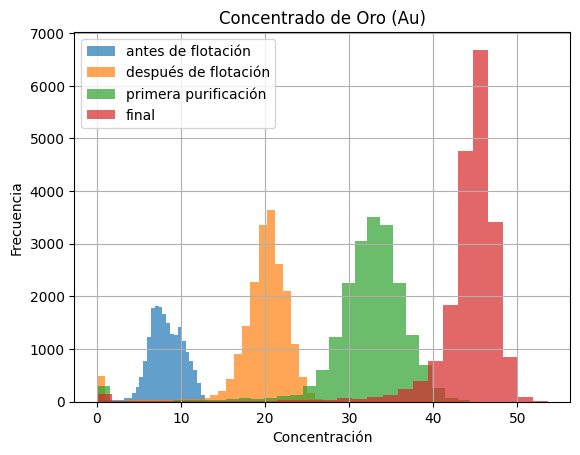

In [33]:
# Lista del concentrado después de cada etapa
concentrate_au = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au',
                  'final.output.concentrate_au']

hist_concentrate(concentrate_au, 'Concentrado de Oro (Au)')

Se observa que los niveles de concentración de Oro van aumentando después de cada etapa, siendo mucho mayor después de la segunda purificación, es decir, al final del proceso. Esto es lo esperado.

Se analizarán los otros dos metales.

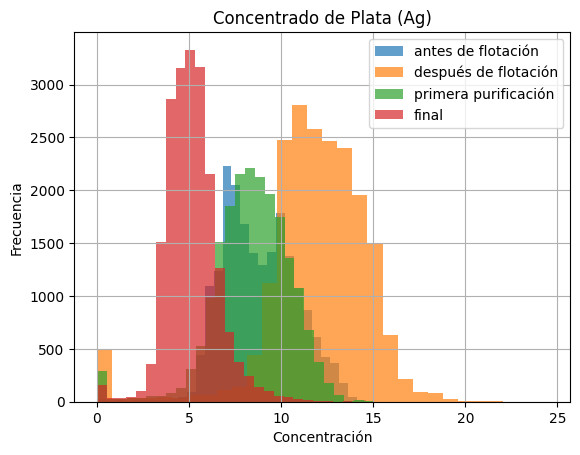

In [34]:
concentrate_ag = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag',
                  'final.output.concentrate_ag']

hist_concentrate(concentrate_ag, "Concentrado de Plata (Ag)")

En el caso de la plata, el comportamiento es distinto. El nivel de concentración aumenta después de la flotación, sin embargo decrece en las últimas dos etapas. De esta manera, la concentración es menor al final del proceso que al inicio.

Finalmente, se analizará el comportamiento del concentrado de plomo.

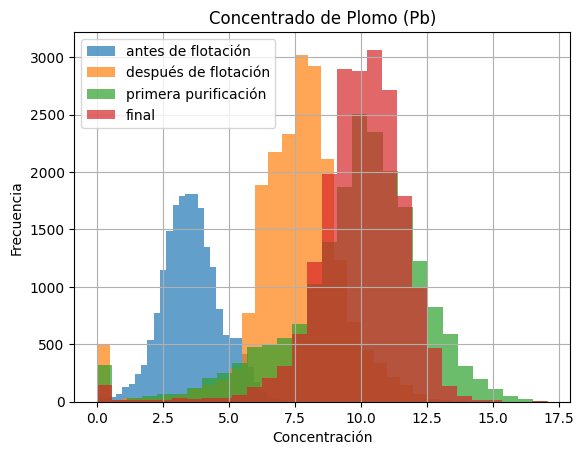

In [35]:
concentrate_pb = ['rougher.input.feed_pb','rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb',
                  'final.output.concentrate_pb']

hist_concentrate(concentrate_pb, "Concentrado de Plomo (Pb)")

Se observa que los niveles de concentración de plomo después de las etapas de purificación (primera y segunda) son similares, aunque en la etapa final hay una mayor cantidad de muestras que alcanzan niveles máximos que después de la primera purificación. Por otro lado, aunque el nivel de concentración después de la flotación es menor, no representa una diferencia muy grande. El nivel de concentración final es mayor que al incio del proceso.

[Volver a Contenidos](#back)

### 2. 2. Tamaño de las partículas en la alimentación <a id='data_analysis_size'></a>

En esta sección se analizarán las distribuciones del tamaño de las partículas de la alimentación tanto en el dataset de entrenamiento como en el de prueba. Estas distribuciones no deberían variar significativamente. Se creará una función para mostrar los histogramas de densidad correspondientes.

In [36]:
def hist_feed_size(item1, item2, title):
    item1.hist(alpha=0.7, bins=30, density=True)
    item2.hist(alpha=0.7, bins=30, density=True)
    plt.legend(['Entrenamiento', 'Prueba'])
    plt.xlabel("Tamaño en la alimentación")
    plt.ylabel("Frecuencia")
    plt.title(title)
    print(f'Media - Entrenamiento: {item1.mean()}')
    print(f'Mediana - Entrenamiento: {item1.median()}')
    print(f'Media - Prueba: {item2.mean()}')
    print(f'Mediana - Prueba: {item2.median()}')

Primero se analizarán las distribuciones del tamaño de las partículas en la alimentación antes de la flotación (rougher).

Media - Entrenamiento: 60.279809316223954
Mediana - Entrenamiento: 55.33515362108768
Media - Prueba: 56.004084088341926
Mediana - Prueba: 50.82213453259382


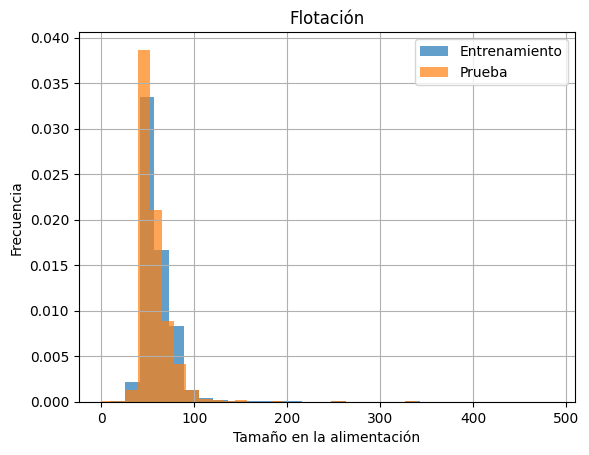

In [37]:
hist_feed_size(train['rougher.input.feed_size'], test['rougher.input.feed_size'], 'Flotación')

Ahora, se analizarán antes de la primera purificación.

Media - Entrenamiento: 7.317692886794572
Mediana - Entrenamiento: 7.289999961853027
Media - Prueba: 7.2666836116966405
Mediana - Prueba: 7.25


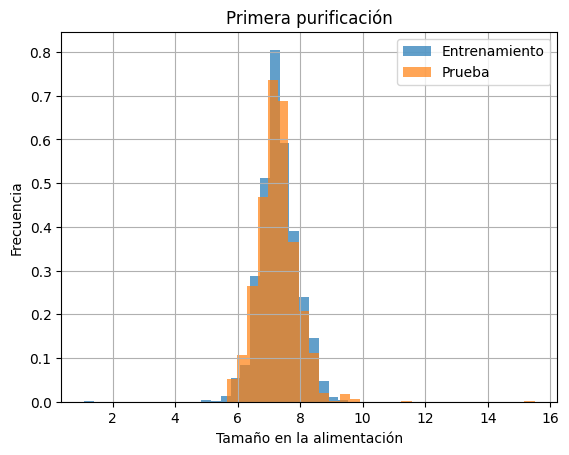

In [38]:
hist_feed_size(train['primary_cleaner.input.feed_size'], test['primary_cleaner.input.feed_size'], 'Primera purificación')

Se observa que en ambos procesos, las distribuciones son muy similares. Esto significa que la evaluación del modelo será correcto.

[Volver a Contenidos](#back)

### 2. 3. Concentraciones totales <a id='data_analysis_total'></a>

En esta sección analizarán las concentraciones totales de todas las sustancias en las diferentes etapas, esto es: materia prima, concentrado rougher y concentrado final.

Para ello, en el dataset completo, se crearán tres columnas: `feed_total`, `rougher_concentrate` y `final_concentrate`. Cada una contendrá las suma de los tres valores correspondientes.

In [39]:
def total_sum(df, item1, item2, item3):
    total = df[item1] + df[item2] + df[item3]
    return total

In [40]:
data['feed_total'] = total_sum(data, 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au')
data['rougher_concentrate'] = total_sum(data, 'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb')
data['final_concentrate'] = total_sum(data, 'final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb')

Se mostrarán los histogramas de cada una de estas columnas para visualizar su distribución.

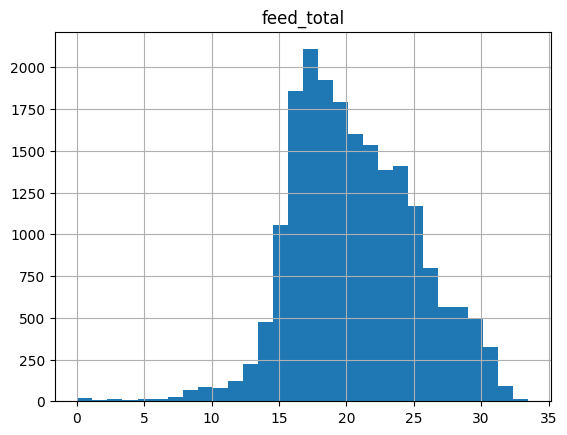

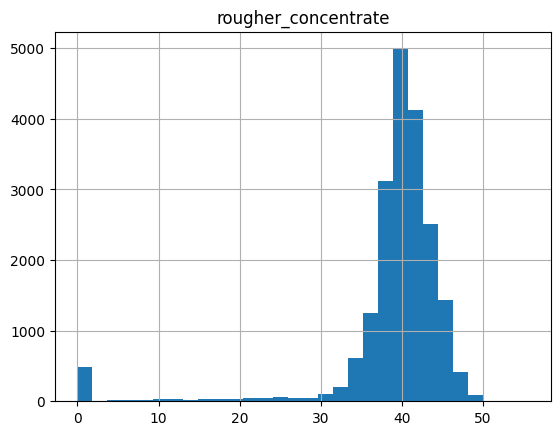

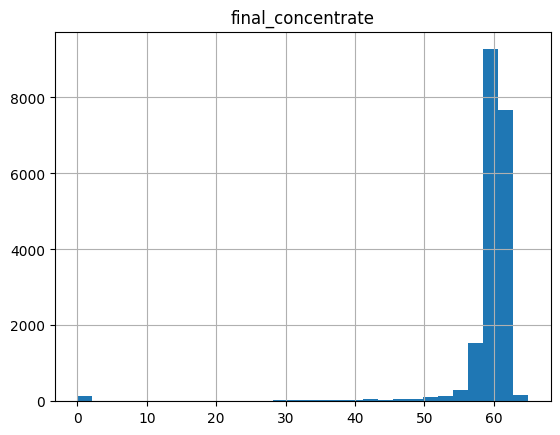

In [41]:
for item in ['feed_total', 'rougher_concentrate', 'final_concentrate']:
    data.hist(item, bins=30, grid=True)

En cada uno se puede apreciar la existencia de valores atípicos. Para averiguar más sobre estos valores se mostrarán diagramas de caja.

In [42]:
# Función para visualizar diagramas de caja
def data_boxplot(df, string):
    df.boxplot(column=string)
    print(df[string].describe())

Primero se visualizará el diagrama para la columna `feed_total`.

count    19847.000000
mean        20.585478
std          4.623166
min          0.030000
25%         17.222951
50%         20.132009
75%         23.786762
max         33.498784
Name: feed_total, dtype: float64


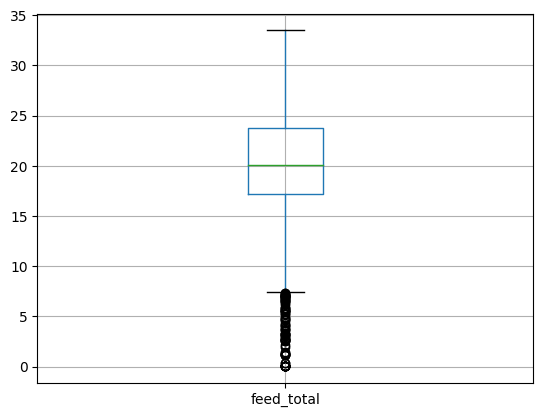

In [43]:
data_boxplot(data, 'feed_total')

Se observa que existen valores atípicos con un valor aproximadamente menor a 7.

A continuación se visualizará el diagrama de caja de la columna `rougher_concentrate`.

count    19847.000000
mean        38.953042
std          7.748673
min          0.000000
25%         38.288962
50%         40.272021
75%         42.338478
max         55.568687
Name: rougher_concentrate, dtype: float64


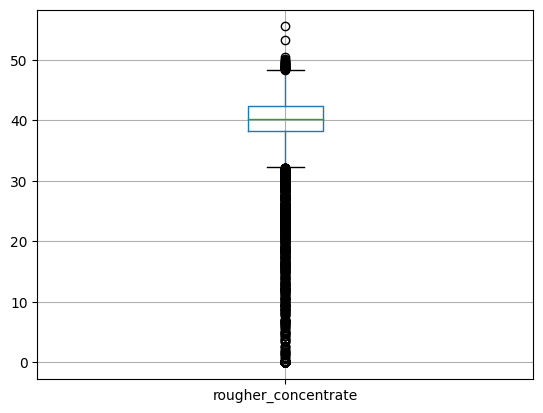

In [44]:
data_boxplot(data, 'rougher_concentrate')

Se observan valores atípicos con un valor aproximadamente mayor a 48, o bien, menor a 32.

Finalmente, se visualizará el diagrama de caja para la columna `final_concentrate`.

count    19847.000000
mean        58.967487
std          7.071208
min          0.000000
25%         59.266203
50%         60.295334
75%         61.093540
max         64.968881
Name: final_concentrate, dtype: float64


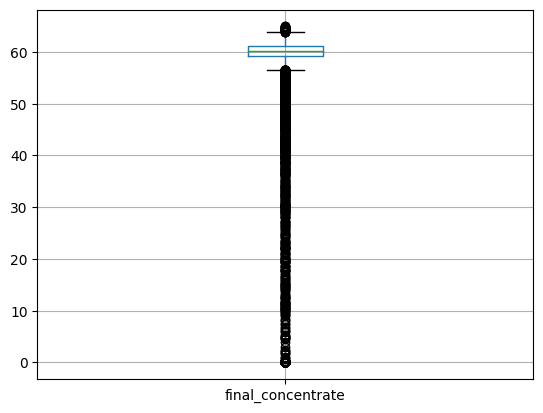

In [45]:
data_boxplot(data, 'final_concentrate')

En esta columna se observan valores atípicos con un valor aproximadamente mayor a 65, o bien, menor a 55.

Para un mejor entrenamiento del modelo, vale la pena eliminar estos valores atípicos. Se crearán dos funciones para calcular los límites superiores e inferiores de cada una de estas columnas.

In [46]:
def lim_sup(string):
    Q1 = data[string].quantile(0.25)
    Q3 = data[string].quantile(0.75)
    IQR = Q3 - Q1
    lim_superior = Q3 + (1.5 * IQR)
    return lim_superior

In [47]:
def lim_inf(string):
    Q1 = data[string].quantile(0.25)
    Q3 = data[string].quantile(0.75)
    IQR = Q3 - Q1
    lim_infe = Q1 - (1.5 * IQR)
    return lim_infe

Se filtrará el conjunto de datos completo sin los valores atípicos.

In [48]:
# limite inferior de feed (no hay atipicos superiores)
li_feed = lim_inf('feed_total')
# límites inferior y superior de rougher
li_rougher = lim_inf('rougher_concentrate')
ls_rougher = lim_sup('rougher_concentrate')
# límites inferior y superior de final
li_final = lim_inf('final_concentrate')
ls_final = lim_sup('final_concentrate')

In [49]:
data_no_outliers = data.query(
    '(@li_feed < feed_total) & (@li_rougher < rougher_concentrate < @ls_rougher) & (@li_final < final_concentrate < @ls_final)'
    ).reset_index(drop=True)
data_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17609 entries, 0 to 17608
Data columns (total 90 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                17609 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         17609 non-null  float64       
 2   final.output.concentrate_pb                         17609 non-null  float64       
 3   final.output.concentrate_sol                        17609 non-null  float64       
 4   final.output.concentrate_au                         17609 non-null  float64       
 5   final.output.recovery                               17609 non-null  float64       
 6   final.output.tail_ag                                17609 non-null  float64       
 7   final.output.tail_pb                                17609 non-null  float64       
 8   final.

Se imprimirán nuevamente los histogramas de cada una de estas tres columnas para comprobar que sus distribuciones no tienen valores atípicos.

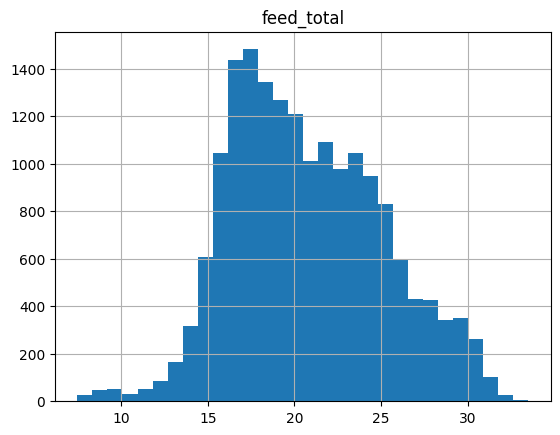

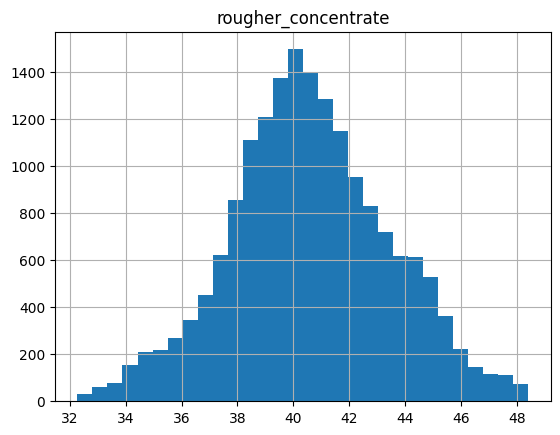

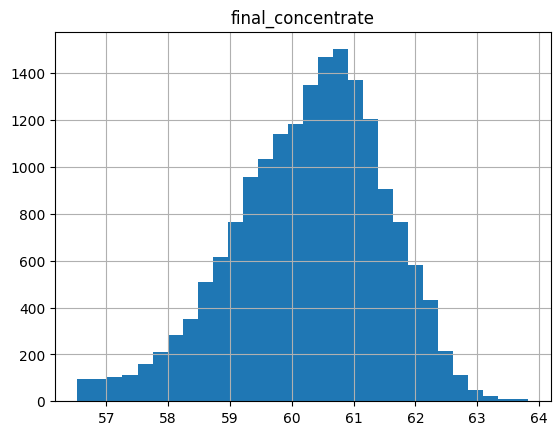

In [50]:
for item in ['feed_total', 'rougher_concentrate', 'final_concentrate']:
    data_no_outliers.hist(item, bins=30, grid=True)

Como se puede apreciar, estas distribuciones ya no tienen valores atípicos. Se filtrarán los datasets de entrenamiento y prueba.

In [51]:
date_list2 = list(data_no_outliers['date'])

train_final = train.query('date in @date_list2').reset_index(drop=True)
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12812 entries, 0 to 12811
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                12812 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         12812 non-null  float64       
 2   final.output.concentrate_pb                         12812 non-null  float64       
 3   final.output.concentrate_sol                        12812 non-null  float64       
 4   final.output.concentrate_au                         12812 non-null  float64       
 5   final.output.recovery                               12812 non-null  float64       
 6   final.output.tail_ag                                12812 non-null  float64       
 7   final.output.tail_pb                                12812 non-null  float64       
 8   final.

In [52]:
test_final = test.query('date in @date_list2').reset_index(drop=True)
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4797 entries, 0 to 4796
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        4797 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               4797 non-null   float64       
 2   primary_cleaner.input.depressant            4797 non-null   float64       
 3   primary_cleaner.input.feed_size             4797 non-null   float64       
 4   primary_cleaner.input.xanthate              4797 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      4797 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    4797 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      4797 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    4797 non-null   float64       
 9   primary_

De esta manera los datatsets no contienen valores atípicos.

[Volver a Contenidos](#back)

### 2. 4. Conclusiones <a id='data_analysis_conclusions'></a>

En esta etapa del proyecto se analizaron los datos, en primer lugar se analizó el comportamiento de las concentraciones de metal (oro, plata y plomo) después de cada etapa del proceso (flotación o rougher, primera purificación y segunda purificación o final). Se encontró que el nivel de concentración de oro crece después de cada etapa. Por el contrario, el nivel de concentración de plata decrece después de cada etapa. En cuanto al nivel de concentración de plomo es similar después de cada una de las etapas.

En la segunda sección se analizaron las distribuciones de los datos sobre el tamaño de las partículas en la alimentación para los conjuntos de entrenamiento y prueba. Se encontró que no existe una diferencia considerable, de manera que la evaluación del modelo será correcta.

Finalmente, en la última sección se analizaron las concentraciones totales de todas las sustancias (oro, plata y plomo) en las diferentes etapas, esto es: materia prima, concentrado rougher y concentrado final. Se encontraron valores atípicos, por lo que se decidión eliminar estas filas pues así se tendrá un mejor entrenamiento para el modelo.

[Volver a Contenidos](#back)

## Etapa 3. Construcción del modelo <a id='data_model'></a>

En esta etapa se creará el modelo y para su evaluación se necesitará la métrica de error medio absoluto porcentual simétrico (sMAPE). Para ello se creará una función.

In [53]:
def final_smape(target, predictions):
    def smape(target, predictions):
        smape = np.mean((np.abs(target - predictions) / ((np.abs(target) + np.abs(predictions)) / 2))) * 100
        return smape
    # sMAPE del concentrado rougher
    smape_r = smape(target[:, 0], predictions[:, 0])
    # sMAPE del concentrado final
    smape_f = smape(target[:, 1], predictions[:, 1])
    result = (0.25 * smape_r) + (0.75 * smape_f)
    return result

El dataset de prueba no contiene las columnas `rougher.output.recovery` y `final.output.recovery`. Se agregarán del conjunto de datos completo. Para ello se creará un dataset temporal con estas columnas y después se unirá al dataset de prueba.

In [54]:
data_temp = data_no_outliers[['date', 'rougher.output.recovery', 'final.output.recovery']]
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17609 entries, 0 to 17608
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     17609 non-null  datetime64[ns]
 1   rougher.output.recovery  17609 non-null  float64       
 2   final.output.recovery    17609 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 412.8 KB


In [55]:
test_final = test_final.merge(data_temp, on='date', how='left')
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4797 entries, 0 to 4796
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        4797 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               4797 non-null   float64       
 2   primary_cleaner.input.depressant            4797 non-null   float64       
 3   primary_cleaner.input.feed_size             4797 non-null   float64       
 4   primary_cleaner.input.xanthate              4797 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      4797 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    4797 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      4797 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    4797 non-null   float64       
 9   primary_

Para entrenar el modelo se considerarán únicamente las columnas de este conjunto de prueba, por lo que se eliminarán las columnas del dataset de entrenamiento que no aparezcan en el de prueba.

In [56]:
train_final = train_final.loc[:, list(test_final.columns)]
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12812 entries, 0 to 12811
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        12812 non-null  datetime64[ns]
 1   primary_cleaner.input.sulfate               12812 non-null  float64       
 2   primary_cleaner.input.depressant            12812 non-null  float64       
 3   primary_cleaner.input.feed_size             12812 non-null  float64       
 4   primary_cleaner.input.xanthate              12812 non-null  float64       
 5   primary_cleaner.state.floatbank8_a_air      12812 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_level    12812 non-null  float64       
 7   primary_cleaner.state.floatbank8_b_air      12812 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_level    12812 non-null  float64       
 9   primar

Se quiere predecir la cantidad de oro extraído del mineral de oro. Por lo tanto, los objetivos del modelo son las columnas `rougher.output.recovery` y `final.output.recovery`. Se establecerán estos objetivos para los conjuntos de prueba y entrenamiento.

In [57]:
targets = ['rougher.output.recovery', 'final.output.recovery']
target_train = train_final[targets]
target_test = test_final[targets]

print(target_train.shape)
print(target_test.shape)

(12812, 2)
(4797, 2)


Para las características de los conjuntos de entrenamiento y prueba, se eliminan las columnas que no pertenecen a los objetivos ni a `date`.

In [58]:
features_train = train_final.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test = test_final.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

print(features_train.shape)
print(features_test.shape)

(12812, 52)
(4797, 52)


Lo último que se debe hacer antes de entrenar el modelo es estandarizar los valores (en este caso todos son numéricos) con el conjunto de entrenamiento.

In [59]:
scaler = StandardScaler()
scaler.fit_transform(features_train)
scaler.transform(features_test)

array([[ 1.97976371,  1.82857279,  1.23263881, ..., -0.42562181,
         1.23936309,  0.21298045],
       [ 2.09913536,  1.82688536,  1.23263881, ..., -0.42899283,
         0.94471638,  0.20984562],
       [ 2.09569039,  1.19854085,  0.75497136, ..., -0.41998465,
         0.94033358,  0.1869629 ],
       ...,
       [ 0.94854255,  2.12758825,  1.21635431, ..., -0.42570305,
        -1.8581649 ,  0.26767218],
       [ 1.17112406,  1.96181872,  1.21635431, ..., -0.4229362 ,
        -1.85281327,  0.20030509],
       [ 1.21947275,  1.82938926,  1.21635431, ..., -0.43372034,
        -1.85701252,  0.18290622]])

En la siguiente sección se determinará el algoritmo para el mejor modelo.

[Volver a Contenidos](#back)

### 3. 1. Entrenamiento del modelo <a id='data_model_train'></a>

Para elegir el mejor modelo se utilizará la métrica sMAPE. Como se evaluará la calidad del modelo por medio de validación cruzada, se debe crear un marcador (scorer) con la función creada para calcular el sMAPE.

In [60]:
# Mide el error, entre menor sea mejor
smape_score = make_scorer(final_smape)

El primer algoritmo para probar es la regresión lineal.

In [61]:
lr_model = LinearRegression()
# Marcadores de la validación cruzada
lr_scores = cross_val_score(lr_model, features_train, target_train.to_numpy(), scoring=smape_score, cv=5)
# Media de los marcadores
print(lr_scores.mean())

9.708433953544901


Ahora se probará con el algoritmo de árbol de decisión variando el parámetro de profundidad.

In [62]:
for depth in range(1, 20):
    dt_model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    dt_scores = cross_val_score(dt_model, features_train, target_train.to_numpy(), scoring=smape_score, cv=5)
    print(f'Media sMAPE: {dt_scores.mean()}, max_depth = {depth}')

Media sMAPE: 8.52156144725499, max_depth = 1
Media sMAPE: 8.803223123818213, max_depth = 2
Media sMAPE: 9.099064924170957, max_depth = 3
Media sMAPE: 11.104658931222207, max_depth = 4
Media sMAPE: 11.010483100945864, max_depth = 5
Media sMAPE: 9.796617020437768, max_depth = 6
Media sMAPE: 10.692412989427202, max_depth = 7
Media sMAPE: 10.60196087419347, max_depth = 8
Media sMAPE: 11.037758554843384, max_depth = 9
Media sMAPE: 12.984748436688843, max_depth = 10
Media sMAPE: 12.131088553643, max_depth = 11
Media sMAPE: 13.865937605371434, max_depth = 12
Media sMAPE: 12.35417996261403, max_depth = 13
Media sMAPE: 12.961825838906233, max_depth = 14
Media sMAPE: 14.242436205912455, max_depth = 15
Media sMAPE: 14.130404580550344, max_depth = 16
Media sMAPE: 12.453959294298016, max_depth = 17
Media sMAPE: 13.592252548146044, max_depth = 18
Media sMAPE: 13.9549886509519, max_depth = 19


El error menor es 8.80 con profundidad máxima de 2, el cual es menor al error  del modelo con regresión lineal. A continuación se entrenará el modelo con el algoritmo de bosque aleatorio únicamente con 30 estimadores. El parámetro a variar es la profundidad máxima.

In [63]:
for i in range(1, 11): #rango de profundidad
    rf_model = RandomForestRegressor(random_state=54321, max_depth=i, n_estimators=30) # n_estimators ajusta el número de árboles
    rf_smape = cross_val_score(rf_model, features_train, target_train.to_numpy(), scoring=smape_score, cv=5)
    smape_mean = rf_smape.mean()
    print(f'Media sMAPE: {smape_mean}, max_depth = {i}')

Media sMAPE: 8.523327530050476, max_depth = 1
Media sMAPE: 8.61788988417776, max_depth = 2
Media sMAPE: 8.416250902459973, max_depth = 3
Media sMAPE: 8.636146472732971, max_depth = 4
Media sMAPE: 8.790700295521534, max_depth = 5
Media sMAPE: 8.780754306630744, max_depth = 6
Media sMAPE: 8.831997245074325, max_depth = 7
Media sMAPE: 8.913617331359442, max_depth = 8
Media sMAPE: 9.055399525974835, max_depth = 9
Media sMAPE: 8.83579929880369, max_depth = 10


Con este algoritmo se obtiene un sMAPE de 8.41 a profundidad máxima igual a 3. Es probable que con una cantidad mayor de estimadores se obtenga un sMAPE menor, sin embargo el tiempo de entrenamiento tiende a ser mucho mayor.

[Volver a Contenidos](#back)

### 3. 2. Prueba final <a id='data_model_train'></a>

El modelo con menor sMAPE fue el entrenado con el algoritmo de bosque aleatorio con 30 estimadores y profundida máxima igual a 10.

Se probará el modelo con el conjunto de prueba.

In [64]:
model = RandomForestRegressor(random_state=54321, max_depth=3, n_estimators=30)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print(final_smape(target_test.to_numpy(), predictions))

6.139900021621274


El modelo tiene un valor sMAPE de 6.13, menor que en la validación cruzada, por lo que es un buen modelo.

[Volver a Contenidos](#back)

## Etapa 4. Conclusión general <a id='data_conclusion'></a>

En la primera etapa se preprocesaron los datos, esto es, se reemplazaron valores asusentes. Los de las columnas correspondientes a la recuperación se reemplazaron con los resultados de las formulas, para las otras columnas se reemplazaron con los valores más cercanos en fecha pues los parámetros son similares por tiempo.

En la segunda etapa se analizaron datos, de donde se conclutó que el nivel de concentración de oro crece después de cada etapa del proceso de purificación, no así con los otros metales (plata y plomo). También se analizaron las distribuciones del tamaño de las partículas en la alimentación para los conjuntos de entrenamiento y prueba. Se concluyó que dichas distribuciones son similares y por lo tanto, la métrica de evaluación para la calidad del modelo es adecuada.

En la tercera etapa se entrenaron modelos para seleccionar el mejor basado en la métrica sMAPE. El modelo con menor error es el entrenado con el algoritmo de bosque aleatorio con 30 estimadores y profundida máxima igual a 3. Al obtener las predicciones en el conjunto de prueba se obtuvo un error menor (sMAPE = 6.13) que en la validación cruzada. Se concluyó que este es el mejor modelo.

[Volver a Contenidos](#back)